# Sentiment Analysis from IMDB Movie Review Dataset 

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords

from deep_translator import GoogleTranslator
# Install the NLTK stopwords list (only need for first time)
# This list contains common words like 'the', 'a', 'is', etc. 
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

In [5]:
df = pd.read_csv("IMDB_Dataset.csv")

print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [6]:
# Get an overview of the dataset
print("\nDataset Information:")
df.info()

# Control the disribution of 'sentiment' column in the dataset
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### Data Preprocessing and Cleaning

In [7]:
# Get meaningless words as a list
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    This function cleans the raw text
    """
    # Remove the HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    words = text.split()
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

In [8]:
print("\nStarting text cleaning...(This may take a while)")
df['cleaned_review'] = df['review'].apply(clean_text)
print("Text cleaning complete!")


Starting text cleaning...(This may take a while)
Text cleaning complete!


In [9]:
print("\nCleaning Data:")
print(df[['review', 'cleaned_review']].head())


Cleaning Data:
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one reviewers mentioned watching 1 oz episode ...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  
3  basically theres family little boy jake thinks...  
4  petter matteis love time money visually stunni...  


### Convert Text to Numerical Format (Vectorization)

In [10]:
# Convert the labels to numerical values
df['sentiment_numeric'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split dataset as features (X) and target (y)
X = df['cleaned_review']
y = df['sentiment_numeric']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

### TF-IDF Vectorization

In [11]:
# Create TF-IDF vectorizer
# max_features=5000 : use the most common 5000 words 
tfidf = TfidfVectorizer(max_features=5000)

### Creating the Model and Training

In [40]:
# Create models
models = {
    "Logistic Regression" : LogisticRegression(max_iter=1000),
    "Linear SVM" : LinearSVC(dual='auto', max_iter=1000),
    "Multinomial Naive Bayes" : MultinomialNB(),
    "Random Forest" : RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    
}

results = []
confusion_matrices = {}
roc_data ={}

for model_name, model in models.items():
    pipeline = Pipeline([
        ('vectorizer', tfidf),
        ('classifier', model)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    
    results.append({
        "Model" : model_name,
        "Accuracy" : accuracy,
        "F1 Score" : f1,
        "Precision" : precision,
        "Recall" : recall
    })
    
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    confusion_matrices[model_name] = cm
    
    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
        y_score = pipeline.predict_proba(X_test)[:,1]
    else:
        y_score = pipeline.decision_function(X_test)
        
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    roc_data[model_name] = (fpr,tpr, y_score)
    

print("-"*50)
print("All models were trained!")
    

--------------------------------------------------
All models were trained!


#### Evaluation the Performance of the Model

In [28]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

print("Table of Performance Comparison")
print(results_df)

Table of Performance Comparison
                     Model  Accuracy  F1 Score  Precision  Recall
0      Logistic Regression    0.8899  0.891044   0.881881  0.9004
1               Linear SVM    0.8829  0.883679   0.877837  0.8896
2  Multinomial Naive Bayes    0.8557  0.856546   0.851552  0.8616
3            Random Forest    0.8503  0.848528   0.858693  0.8386


C:\Users\CASPER\AppData\Local\Temp\ipykernel_14732\941083624.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Accuracy", y="Model", data=results_df, palette="Blues")


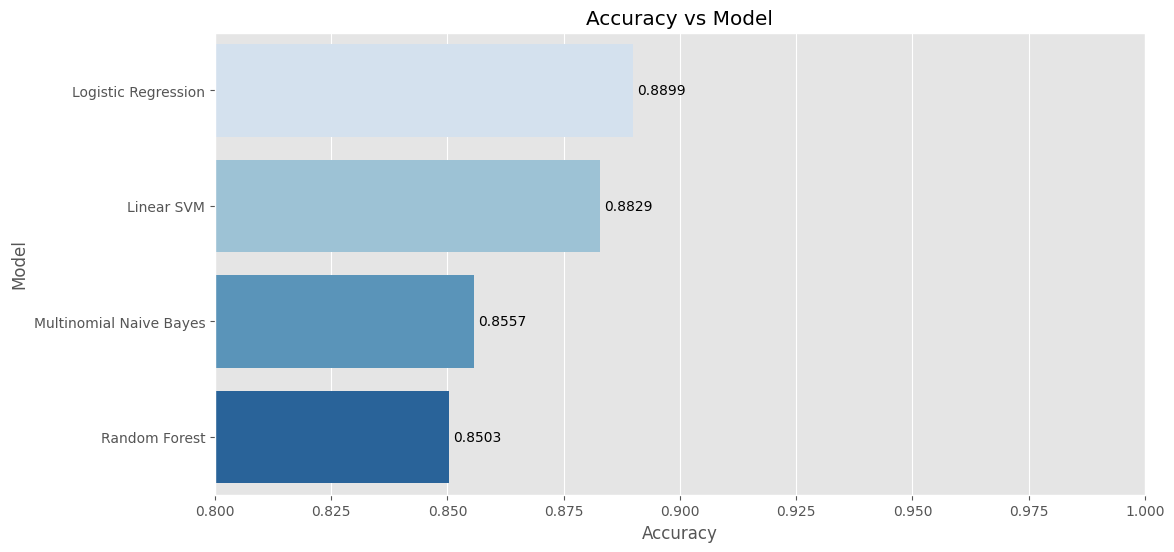

In [29]:
plt.figure(figsize=(12,6))

ax = sns.barplot(x="Accuracy", y="Model", data=results_df, palette="Blues")
plt.title("Accuracy vs Model")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0.8,1.0)

for i in ax.containers:
    ax.bar_label(i,fmt='%.4f' , padding=3)
    
plt.show()

In [31]:
print(confusion_matrices)

{'Logistic Regression': array([[0.8794, 0.1206],
       [0.0996, 0.9004]]), 'Linear SVM': array([[0.8762, 0.1238],
       [0.1104, 0.8896]]), 'Multinomial Naive Bayes': array([[0.8498, 0.1502],
       [0.1384, 0.8616]]), 'Random Forest': array([[0.862 , 0.138 ],
       [0.1614, 0.8386]])}


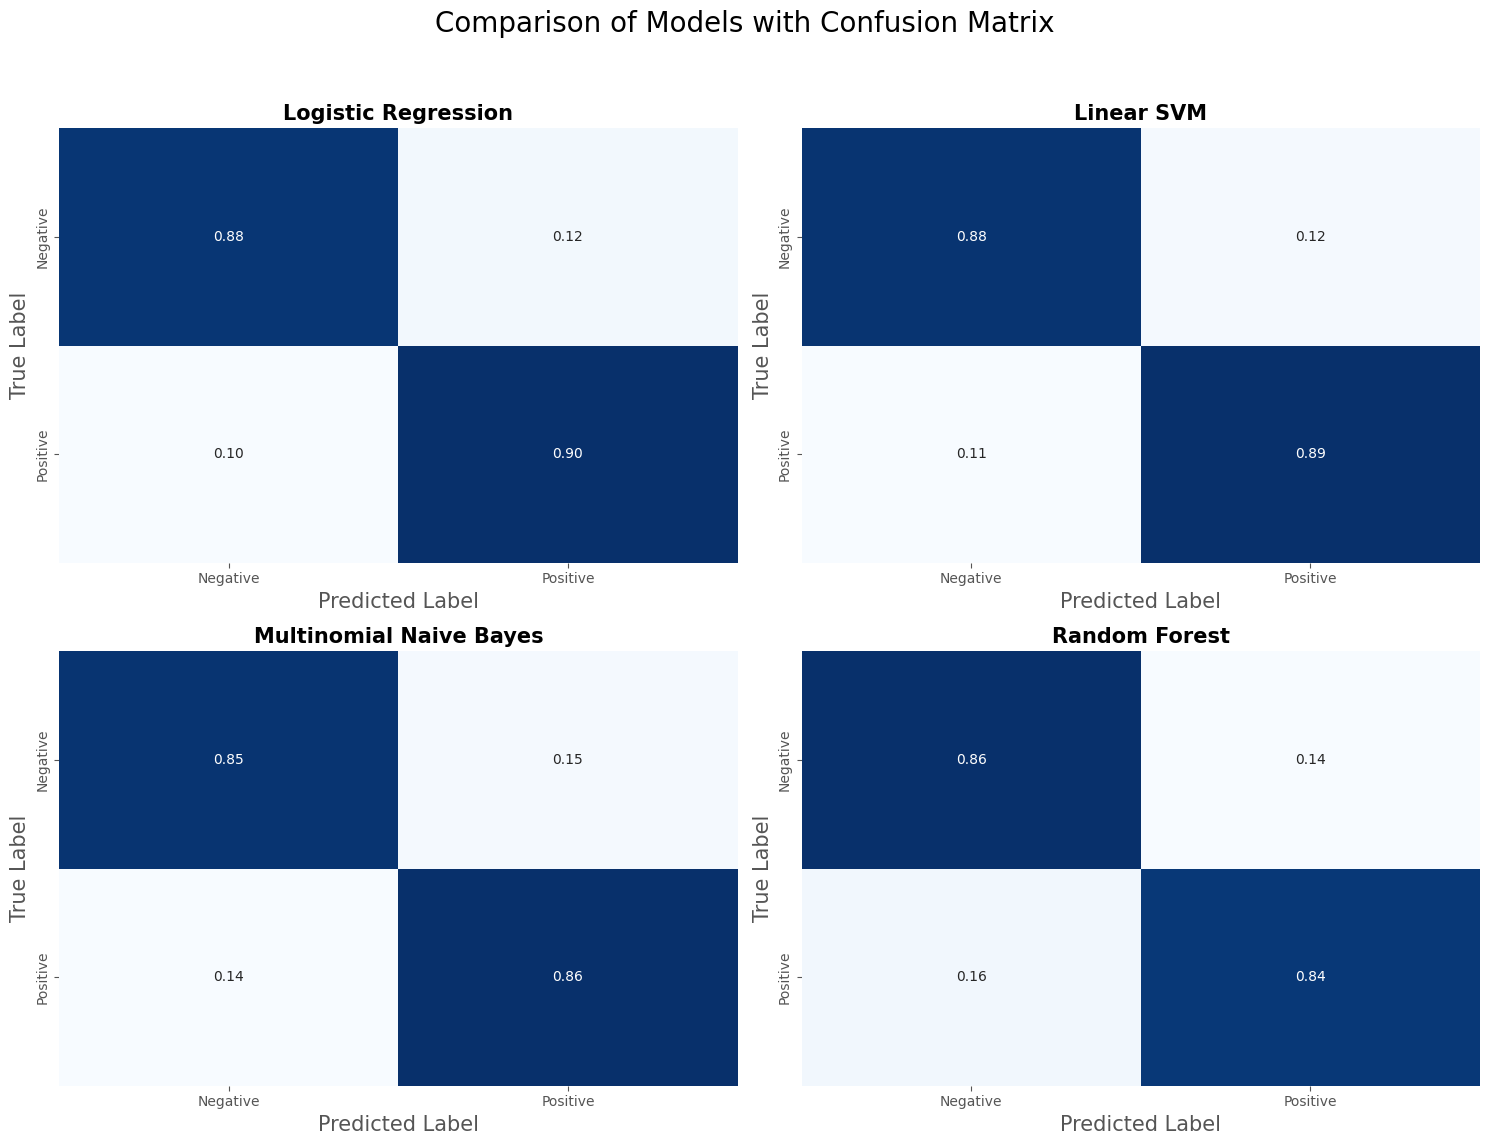

In [33]:
plt.style.use('ggplot')

fig, axes = plt.subplots(2,2, figsize=(15, 12))
fig.suptitle("Comparison of Models with Confusion Matrix", fontsize=20)

axes_flat = axes.flatten()

for (model_name, cm), ax in zip(confusion_matrices.items(), axes_flat):
    
    sns.heatmap(cm, annot=True, fmt='.2f', cmap="Blues" , ax=ax, cbar=False,
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    
    ax.set_title(f"{model_name}", fontsize=15, fontweight='bold')
    ax.set_ylabel("True Label", fontsize=15)
    ax.set_xlabel("Predicted Label", fontsize=15)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

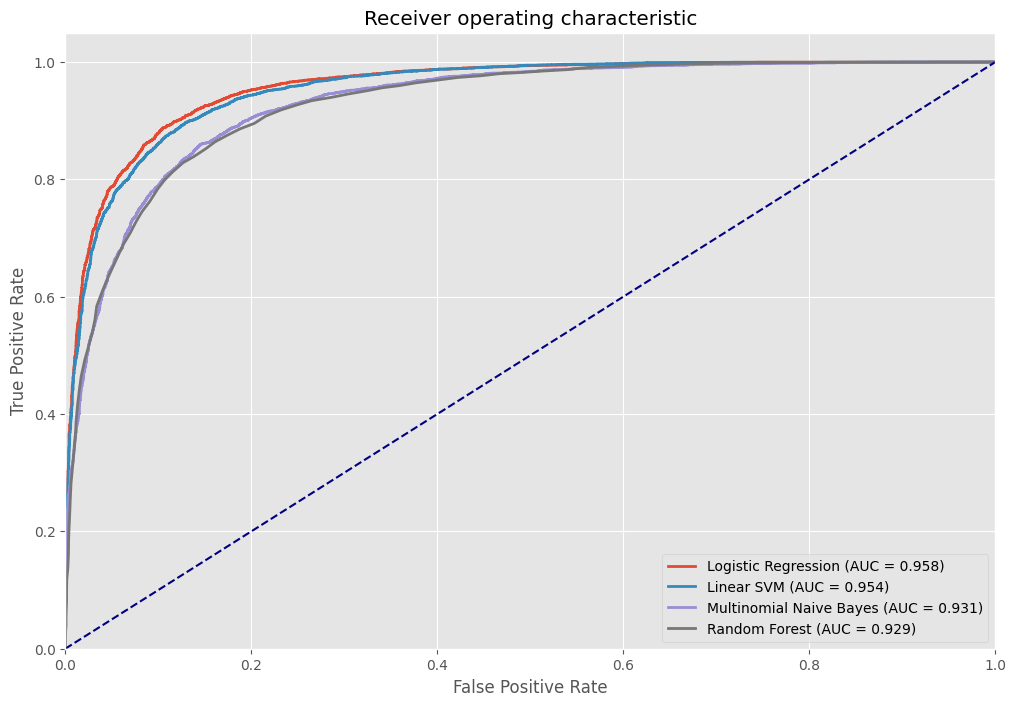

In [41]:
plt.figure(figsize=(12,8))

for name, (fpr, tpr, roc_auc) in roc_data.items():
    roc_auc_score = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc_score:.3f})')
    
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Testing Model with New Reviews

In [47]:
best_model_info = results_df.iloc[0]
best_model_name = best_model_info['Model']
best_accuracy = best_model_info['Accuracy']

best_model = models[best_model_name]

print("Choosen best model is: ", best_model_name)
print(f"Accuracy of the best model is: %{best_accuracy*100:.2f}")


Choosen best model is:  Logistic Regression
Accuracy of the best model is: %88.99


In [55]:
def predict_sentiment(review):
    
    cleaned_review = clean_text(review)
    
    vectorized_review = tfidf.transform([cleaned_review])
    
    prediction = best_model.predict(vectorized_review)[0]
    sentiment = "POSITIVE" if prediction ==1 else "NEGATIVE"
    
    if hasattr(best_model, "predict_proba"):
        probs = best_model.predict_proba(vectorized_review)[0]
        confidence = probs[prediction]
        print(f"Review: '{review}'")
        print(f"Prediction: {sentiment} (Confidence: %{confidence*100:.2f})")
    else:
        score = best_model.decision_function(vectorized_review)[0]
        
        confidence = 1/ (1+ np.exp(-abs(score)))
        print(f"Review: '{review}'")
        print(f"Prediction: {sentiment} (SVM Score: {score:.2f})")

In [51]:
predict_sentiment("This movie was absolutely masterpiece! The acting was incredible.")

Review: 'This movie was absolutely masterpiece! The acting was incredible.'
Prediction: POSITIVE (Confidence: %92.21)


In [52]:
predict_sentiment("The plot was confusing and the characters were shallow. Not recommended.")

Review: 'The plot was confusing and the characters were shallow. Not recommended.'
Prediction: NEGATIVE (Confidence: %87.34)


### Addition

If review is not English, translate it to English and then analyze it.

In [64]:
def check_and_translate(text):
    """
    Check if the text is english and translate it if not.

    Args:
        text (_type_): non-english text
    """
    
    try:
        translated = GoogleTranslator(source="auto", target="en").translate(text)
        return translated
    except:
        print("Service of translation is not available.")
        return text

In [65]:
def predict_sentiment(review):
    
    processed_review = check_and_translate(review)
    
    if review != processed_review:
        print("Foreign language is detected. It turned to English.")
        print(f"Original: '{review}'")
        print(f"Translated: '{processed_review}'")
        print("-"*30)
    
    cleaned_review = clean_text(processed_review)
    
    vectorized_review = tfidf.transform([cleaned_review])
    
    prediction = best_model.predict(vectorized_review)[0]
    sentiment = "POSITIVE" if prediction ==1 else "NEGATIVE"
    
    if hasattr(best_model, "predict_proba"):
        probs = best_model.predict_proba(vectorized_review)[0]
        confidence = probs[prediction]
        print(f"Review: '{review}'")
        print(f"Prediction: {sentiment} (Confidence: %{confidence*100:.2f})")
    else:
        score = best_model.decision_function(vectorized_review)[0]
        
        confidence = 1/ (1+ np.exp(-abs(score)))
        print(f"Review: '{review}'")
        print(f"Prediction: {sentiment} (SVM Score: {score:.2f})")

### Test

In [66]:
predict_sentiment("Bu film hayatımda izlediğim en kötü şeydi.")

Foreign language is detected. It turned to English.
Original: 'Bu film hayatımda izlediğim en kötü şeydi.'
Translated: 'This movie was the worst thing I've ever seen in my life.'
------------------------------
Review: 'Bu film hayatımda izlediğim en kötü şeydi.'
Prediction: NEGATIVE (Confidence: %97.51)
